# 1. Potential energy surface (PES)

- The datapoints (i.e. deformed structures) are generated by a linear interpolation between equilibrium configurations of excited (initial) and ground (final) states, which can be obtained by [gen_cc_struct.py](https://github.com/WMD-group/CarrierCapture.jl/blob/master/script/gen_cc_struct.py)

- The PES is plotted as a function of one-dimensional (1D) generalised configuration coordinate *Q*, which can be obtained by [get_del_Q.py](https://github.com/WMD-group/CarrierCapture.jl/blob/master/script/get_del_Q.py). $\Delta Q$ is a collective variable of the mass-weighted deformation $\Delta Q =\sum m \Delta R$.

- Make sure all datapoints used for fitting are in-gap localised states. This can be checked via eigenvalue vs Q plot (by [get_eig.py](https://github.com/WMD-group/CarrierCapture.jl/blob/master/script/get_eig.py)).

In [1]:
using Pkg
using CarrierCapture
using Plots, LaTeXStrings, Format
using DataFrames, CSV, YAML
using Dierckx
using PyCall
@show VERSION

VERSION = v"1.8.1"


v"1.8.1"

In [2]:
ENV["PYTHON"] = "/storage/work/ash5615/bin/.conda/envs/raddefects/bin/python3.12"
Pkg.build("PyCall")

    Building Conda ─→ `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/b19db3927f0db4151cb86d073689f2428e524576/build.log`
    Building PyCall → `~/.julia/scratchspaces/44cfe95a-1eb2-52ea-b672-e2afdf69b78f/9816a3826b0ebf49ab4926e2b18842ad8b5c8f04/build.log`


In [38]:
defect_data = YAML.load_file("carrier_capture_params.yaml")

Dict{Any, Any} with 22 entries:
  "cbm"              => 3.59833
  "q_initial"        => -1
  "vbm"              => 2.6e-5
  "formation energy" => -1.34314
  "Eg"               => 3.55589
  "conduction bands" => "[432]"
  "valence bands"    => "[429, 430, 431]"
  "Qmin"             => -2.8
  "defect"           => "C_N1"
  "dielectric"       => 11.7124
  "m_e"              => 0.2
  "g"                => 4
  "Wif_h"            => 0.0976378
  "Qmax"             => 2.8
  "coupling state"   => "final"
  "Q0"               => 0.0
  "m_h"              => 0.8
  "Wif_e"            => 0.0607787
  "volume"           => 1099.98
  "ctl"              => 1.00475
  "q_final"          => 0
  "dQ"               => 1.43636

In [3]:
delQ = defect_data["dQ"]
Qmin = floor(defect_data["Qmin"]*1.2)
Qmax = ceil(defect_data["Qmax"]*1.2)
NQ = 300
Q = range(Qmin, stop=Qmax, length=NQ)

-6.0:0.04013377926421405:6.0

In [4]:
defect_name = replace(defect_data["defect"], r"\d" => "")
q_initial = defect_data["q_initial"]
q_final = defect_data["q_final"]
sign_initial = replace(string(sign(q_initial)), "1" => "")
sign_final = replace(string(sign(q_final)), "1" => "")
q_diff = q_final-q_initial
i_str = "i_q"
f_str = format(FormatExpr("f_q{:+d}"), q_diff)

"f_q+1"

## 1.2. HSE

In [5]:
i_disp = CSV.read(i_str * "/potential.csv", DataFrame)
f_disp = CSV.read(f_str * "/potential.csv", DataFrame)

Row,Q,E
,Float64,Float64
1,-4.02182,-738.735
2,-3.16,-739.718
3,-2.29818,-740.49
4,-1.43636,-741.032
5,-0.861819,-741.259
6,-0.574546,-741.33
7,-0.287273,-741.373
8,-0.143636,-741.384
9,0.0,-741.387


In [22]:
nev = 200  # make sure you include enough number of states to describe the carrier-cature behaviour

# pot1 -> final state + electron in CBM + hole in VBM
name = L"%$defect_name^%$sign_final\ + e^{\-}_{ CBM} + h^{\+}_{ VBM}  \ \ (^{}$$"
Q1 = f_disp[!, "Q"]
E1 = f_disp[!, "E"]

pot1 = Potential(); pot1.name = name
pot1.nev = nev
pot1.Q0 = Q1[findmin(E1)[2]]; pot1.E0 = defect_data["Eg"]
pot1.QE_data = DataFrame(Q = Q1[:], E = E1[:])
pot1.QE_data.E .+= - minimum(pot1.QE_data.E) + pot1.E0
pot1.Q = Q

pot1.func_type = "spline"
fit_pot!(pot1)

# pot2 -> initial state + hole in VBM
name = L"%$defect_name^%$sign_initial\ + h^{\+}_{ VBM} \ \ (^{}$$"
Q2 = i_disp[!, "Q"]
E2 = i_disp[!, "E"]

pot2 = Potential(); pot2.name = name
pot2.nev = nev
pot2.Q0 = Q2[findmin(E2)[2]]; pot2.E0 = defect_data["ctl"]
pot2.QE_data = DataFrame(Q = Q2[:], E = E2[:])
pot2.QE_data.E .+= - minimum(pot2.QE_data.E) + pot2.E0
pot2.Q = Q

pot2.func_type = "spline"
fit_pot!(pot2)

# pot3 -> final state
name = L"%$defect_name^%$sign_final\  \ \ (^{}$$"
Q3 = f_disp[!, "Q"]
E3 = f_disp[!, "E"]

pot3 = Potential(); pot3.name = name
pot3.nev = nev
pot3.Q0 = Q3[findmin(E3)[2]]; pot3.E0 = 0.
pot3.QE_data = DataFrame(Q = Q3[:], E = E3[:])
pot3.QE_data.E .+= - minimum(pot3.QE_data.E) + pot3.E0
pot3.Q = Q

pot3.func_type = "spline"
fit_pot!(pot3)

"fitting completed"

Potential fitting: C_N^0\ + e^{\-}_{ CBM} + h^{\+}_{ VBM}  \ \ (^{}$$
=========spline==========

Potential fitting: C_N^-\ + h^{\+}_{ VBM} \ \ (^{}$$
=========spline==========

Potential fitting: C_N^0\  \ \ (^{}$$
=========spline==========



"fitting completed"

In [7]:
# calculate decrease in VBM based on a given temperature for experimental comparison

In [23]:
# pot2+
pot2plus = Potential(); pot2plus.name = pot2.name
pot2plus.nev = pot2.nev
pot2plus.Q0 = pot2.Q0; pot2plus.E0 = pot2.E0 + 0.05
pot2plus.QE_data = DataFrame(Q = Q2[:], E = E2[:])
pot2plus.QE_data.E .+= - minimum(pot2plus.QE_data.E) + pot2plus.E0
pot2plus.Q = Q

pot2plus.func_type = "spline"
fit_pot!(pot2plus)

# pot2-
pot2minus = Potential(); pot2minus.name = pot2.name
pot2minus.nev = pot2.nev
pot2minus.Q0 = pot2.Q0; pot2minus.E0 = pot2.E0 - 0.05
pot2minus.QE_data = DataFrame(Q = Q2[:], E = E2[:])
pot2minus.QE_data.E .+= - minimum(pot2minus.QE_data.E) + pot2minus.E0
pot2minus.Q = Q

pot2minus.func_type = "spline"
fit_pot!(pot2minus)

# pot2exp
pot2exp = Potential(); pot2exp.name = pot2.name
pot2exp.nev = pot2.nev
pot2exp.Q0 = pot2.Q0; pot2exp.E0 = pot2.E0 - 0.13 # will replace with VBM shift T-dependent function
pot2exp.QE_data = DataFrame(Q = Q2[:], E = E2[:])
pot2exp.QE_data.E .+= - minimum(pot2exp.QE_data.E) + pot2exp.E0
pot2exp.Q = Q

pot2exp.func_type = "spline"
fit_pot!(pot2exp)

"fitting completed"

Potential fitting: C_N^-\ + h^{\+}_{ VBM} \ \ (^{}$$
=========spline==========

Potential fitting: C_N^-\ + h^{\+}_{ VBM} \ \ (^{}$$
=========spline==========

Potential fitting: C_N^-\ + h^{\+}_{ VBM} \ \ (^{}$$
=========spline==========



"fitting completed"

In [24]:
solve_pot!(pot1)
solve_pot!(pot2)
solve_pot!(pot3)
"Schrödinger equation solved"

"Schrödinger equation solved"

In [25]:
solve_pot!(pot2plus)
solve_pot!(pot2minus)
solve_pot!(pot2exp)
"Schrödinger equation solved for uncertainty"

"Schrödinger equation solved for uncertainty"

In [29]:
Qx_h, Ex_h = find_crossing(pot2, pot3)
println("Hole capture barrier: $(Ex_h-pot2.E0) eV")
Qx_e, Ex_e = find_crossing(pot1, pot2)
println("Electron capture barrier: $(Ex_e-pot1.E0) eV")

Hole capture barrier: 1.3993835491644435 eV
Electron capture barrier: 1.6898843662159857 eV


In [30]:
Qx_h_exp, Ex_h_exp = find_crossing(pot2exp, pot3)
println("Hole capture barrier (finite T): $(Ex_h_exp-pot2exp.E0) eV")
Qx_e_exp, Ex_e_exp = find_crossing(pot1, pot2exp)
println("Electron capture barrier (finite T): $(Ex_e_exp-pot1.E0) eV")

Hole capture barrier (finite T): 0.5291962071383071 eV
Electron capture barrier (finite T): 1.896874070155766 eV


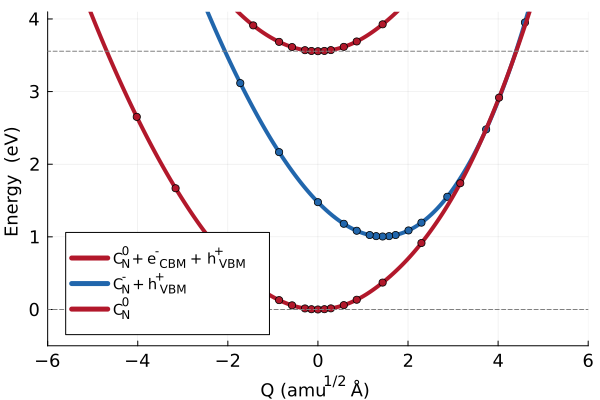

In [31]:
plt_cc = plot(legendfontsize=10, legend=:bottomleft, yaxis = font(12), xaxis = font(12), dpi=1000)  # , size = (1000, 600))
Plotter.plot_pot!(pot1; lplt_wf = false, plt = plt_cc, color = "#b2182b")
Plotter.plot_pot!(pot2; lplt_wf = false, plt = plt_cc, color = "#2166ac")
Plotter.plot_pot!(pot3; lplt_wf = false, plt = plt_cc, color = "#b2182b")
Plotter.hline!([defect_data["Eg"]], label=false, linestyle=:dash, color=:grey)
# Plotter.hline!([pot2.E0], label=false, linestyle=:dash, color=:grey)
Plotter.hline!([0.], label=false, linestyle=:dash, color=:grey)
xlims!((Qmin, Qmax))
ylims!((defect_data["vbm"]-0.5, defect_data["cbm"]+0.5))
savefig("./config-coord-dia.png")

## 1.4. Eigenvalues

In [32]:
"""
    plot_qeig!(Q, eigvals_occ; spin, state, bandgap, plt = nothing, label = "", lt = :none, markerstyle = [:utriangle, :dtriangle], color = nothing)

Plots eigenvalues from a series of configuration coordinate displacement calculations.
"""
function plot_qeig!(
    Q::Float64, eigvals_occ::Matrix; spin::String, state::String, bandgap::Float64, plt = nothing, label = "", lt = :none, markershapes = [:utriangle, :dtriangle], color = nothing
    )
    if plt == nothing
        plt = plot(legendfontsize=10, legend=:topleft, yaxis=font(12), xaxis=font(12), dpi=1000, show=true)
    end
    label = if label == "" "" else label end
    markershapes = if spin == "up" markershapes[1] elseif spin == "down" markershapes[2] else :circle end
    # color based on occupation, unoccupied for 0-0.3, partially occupied for 0.3-0.9, and occupied for 0.9-1
    color = if color == nothing cgrad(:acton, [0.3, 0.9], rev = true, categorical = true) else color end
    markerstrokecolor = if state == "initial" "#2166ac" elseif state == "final" "#b2182b" else :black end

    Qi = fill(Q, size(eigvals_occ, 1))

    # plot data
    if size(eigvals_occ, 1) > 1
        scatter!(plt, Qi, eigvals_occ[:, 1],
                 markershapes = markershapes,
                 markerstrokewidth = 0.75,
                 markerstrokecolor = markerstrokecolor,
                 color = color[eigvals_occ[:, 2]],
                 label = ""
                 )
    end
    
    xaxis!(L"\ Q (amu^{1\/2} Å) \ (^{}$$"); yaxis!(L"\ Energy  (eV) \ (^{}$$")
    
    hline!([bandgap], label="", linestyle=:dash, color = "#000000")
    hline!([0.], label="", linestyle=:dash, color = "#000000")
    
    xlims!(-ceil(Q), ceil(Q))
    ylims!(-2., ceil(bandgap)+2.)

    return plt
end

plot_qeig!

In [ ]:
using PyCall

py"""
from pymatgen.io.vasp.outputs import Eigenval, Vasprun
from pymatgen.electronic_structure.core import Spin
from pathlib import Path


def parse_eigvals_for_q(qpath):
    # for a given Q value, gather eigenvalues by reading in file to pymatgen
    q_vasprun = Vasprun(Path(qpath) / 'vasprun.xml',
                        parse_dos=False,
                        parse_potcar_file=False,
                        separate_spins=True
                        )
    # final eigenvals as a dict of {(spin, kpoint index):[[eigenvalue, occu]]} with kpt 0-based idx
    q_eigvals = q_vasprun.eigenvalues

    # get band properties from vasprun file as a tuple of (band gap, cbm, vbm, is_band_gap_direct)
    # each property is a list with idx 0 = spin-up channel and idx 1 = spin-down channel
    q_band_props = q_vasprun.eigenvalue_band_properties
    vbm = q_band_props[2]

    # adjust eigenvalues such that the VBM is aligned with 0 eV
    q_eigvals[Spin.up][:, :, 0] -= vbm[0]
    q_eigvals[Spin.down][:, :, 0] -= vbm[1]

    return q_eigvals


def julia_spin(orientation):
    if orientation == 'up':
        jspin = Spin.up
    elif orientation == 'down':
        jspin = Spin.down
    return jspin
"""


"""
    calc_qeig!(disp_dir, disp_vec, dQ, state; bandgap, kpt_idx = 1, plt = nothing)

Gathers, analyzes, and plots eigenvalues from a series of configuration coordinate displacement calculations. Defaults to eigenvalues at the gamma-point.
"""
function calc_qeig!(
    disp_dir::String, disp_vec::Vector{Float64}, dQ::Float64, state::String; bandgap::Float64, kpt_idx = 1, plt = nothing,
    )
    if plt == nothing
        plt = plot(legendfontsize=10, legend=:topleft, yaxis=font(12), xaxis=font(12), dpi=600, show=true)
    end

    # get Q path using Q disp array/vector, use f-string formatting to convert from value to DISP_XXX format, specify base directory for charge
    fe = FormatExpr("{:s}/DISP_{:0>3s}")
    
    # parse eigvals for each Q value in Q disp vector (corresponding to config. coord. diagram)
    for q in disp_vec
        q = if q == -0.0 0.0 else q end
        # format string for each displacement directory
        qi_dir = format(fe, disp_dir, replace(string(q), "." => ""))

        # parse eigenvalues for a single displacement calculation and split into spin up/down matrices
        spin_up_matrix = py"parse_eigvals_for_q"(qi_dir)[py"julia_spin('up')"][kpt_idx, :, :]
        spin_down_matrix = py"parse_eigvals_for_q"(qi_dir)[py"julia_spin('down')"][kpt_idx, :, :]

        # calculate Q value from relative displacement
        Qi = if state == "initial" q*dQ+dQ elseif state == "final" q*dQ else throw("Please specify initial/final as the state.") end

        # plot eigenvalues for a single displacement calculation
        plot_qeig!(Qi, spin_up_matrix, spin="up", state=state, bandgap=bandgap, plt=plt)
        plot_qeig!(Qi, spin_down_matrix, spin="down", state=state, bandgap=bandgap, plt=plt)
    end

    return plt
end

calc_qeig!

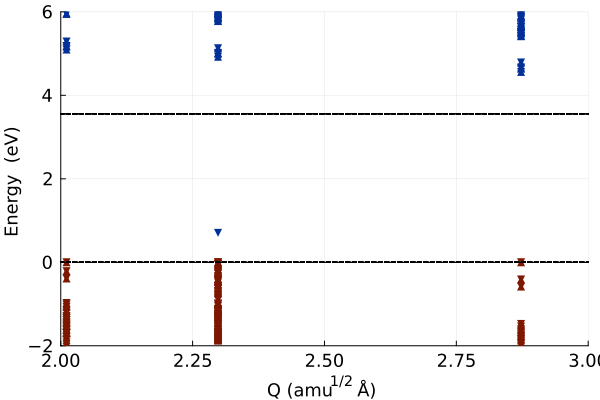

In [ ]:
KPT_IDX = 1
plt_eigs = plot(legendfontsize=10, legend=:topleft, yaxis=font(12), xaxis=font(12), dpi=600, show=true)
calc_qeig!(f_str, round.(f_disp[!, "Q"]/delQ, digits=1), delQ, "final"; bandgap = defect_data["Eg"], kpt_idx = KPT_IDX, plt = plt_eigs)
calc_qeig!(i_str, round.((i_disp[!, "Q"].-delQ)/delQ, digits=1), delQ, "initial"; bandgap = defect_data["Eg"], kpt_idx = KPT_IDX, plt = plt_eigs)

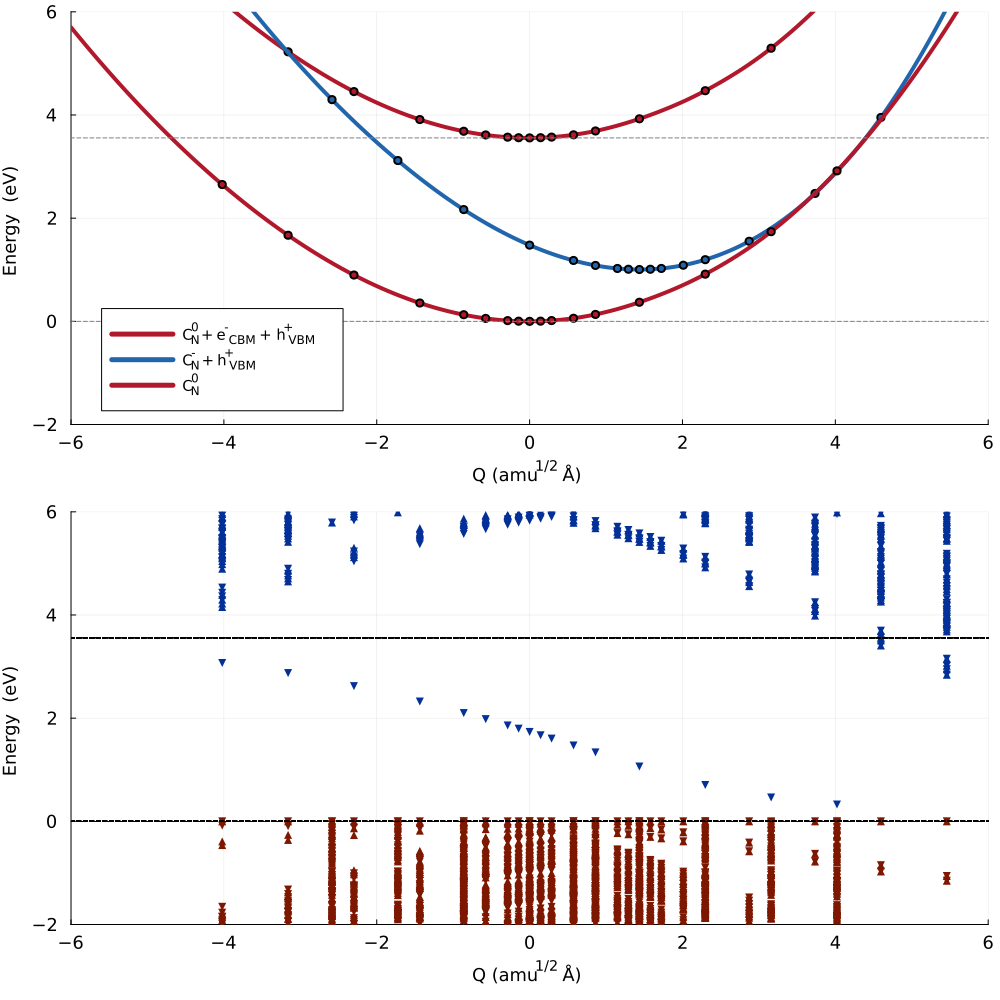

In [35]:
l = @layout [a ; b]
plot(plt_cc, plt_eigs, layout = l, size=(1000, 1000), dpi=1000)
xlims!((Qmin, Qmax))
ylims!((-2., 6.))
savefig("./cc-eigs.png")

# 2. Capture coefficient and cross section

## 2.1 Capture parameters & coefficients

In [39]:
Tmin = 10
Tmax = 800
NT = 100
temperature = range(Tmin, stop=Tmax, length=NT)
volume = defect_data["volume"]*(1e-8)^3 # structure.volume (Ang.^3) * (1e-8 cm/Ang.)^3

Q₀ = defect_data["Q0"] * delQ
g = defect_data["g"] # degeneracy of the final state
cut_off = 0.25
σ = 0.01

Z_h = q_initial/1
Z_e = q_initial/-1
m_h = defect_data["m_h"]
m_e = defect_data["m_e"]
ϵ_0 = defect_data["dielectric"]

11.712438

### Hole capture

In [40]:
W_h = defect_data["Wif_h"] # e-ph coupling

# build a configuration coordinate for the hole capture
cc_h = conf_coord(pot2, pot3)
cc_h.W = W_h
cc_h.g = g
calc_overlap!(cc_h; cut_off = cut_off, σ = σ, Q₀ = Q₀)
calc_capt_coeff!(cc_h, volume, temperature)

10.0:7.97979797979798:800.0

In [41]:
# add uncertainty and 600 K comparison
cc_hplus = conf_coord(pot2plus, pot3)
cc_hplus.W = cc_h.W
cc_hplus.g = cc_h.g
calc_overlap!(cc_hplus; cut_off = cut_off, σ = σ, Q₀ = Q₀)
calc_capt_coeff!(cc_hplus, volume, temperature)

cc_hminus = conf_coord(pot2minus, pot3)
cc_hminus.W = cc_h.W
cc_hminus.g = cc_h.g
calc_overlap!(cc_hminus; cut_off = cut_off, σ = σ, Q₀ = Q₀)
calc_capt_coeff!(cc_hminus, volume, temperature)

cc_hexp = conf_coord(pot2exp, pot3)
cc_hexp.W = cc_h.W
cc_hexp.g = cc_h.g
calc_overlap!(cc_hexp; cut_off = cut_off, σ = σ, Q₀ = Q₀)
calc_capt_coeff!(cc_hexp, volume, temperature)

10.0:7.97979797979798:800.0

### Electron capture

In [42]:
W_e = defect_data["Wif_e"] # e-ph coupling

# build a configuration coordinate for the hole capture
cc_e = conf_coord(pot1, pot2)
cc_e.W = W_e
cc_e.g = g
calc_overlap!(cc_e; cut_off = cut_off, σ = σ, Q₀ = Q₀)
calc_capt_coeff!(cc_e, volume, temperature)

10.0:7.97979797979798:800.0

In [44]:
# add uncertainty and 600 K comparison
cc_eplus = conf_coord(pot1, pot2plus)
cc_eplus.W = cc_e.W
cc_eplus.g = cc_e.g
calc_overlap!(cc_eplus; cut_off = cut_off, σ = σ, Q₀ = Q₀)
calc_capt_coeff!(cc_eplus, volume, temperature)

cc_eminus = conf_coord(pot1, pot2minus)
cc_eminus.W = cc_e.W
cc_eminus.g = cc_e.g
calc_overlap!(cc_eminus; cut_off = cut_off, σ = σ, Q₀ = Q₀)
calc_capt_coeff!(cc_eminus, volume, temperature)

cc_eexp = conf_coord(pot1, pot2exp)
cc_eexp.W = cc_e.W
cc_eexp.g = cc_e.g
calc_overlap!(cc_eexp; cut_off = cut_off, σ = σ, Q₀ = Q₀)
calc_capt_coeff!(cc_eexp, volume, temperature)

10.0:7.97979797979798:800.0

## 2.2 Scaling factors

In [45]:
"""
    calc_charged_supercell_factor!(q_final, q_initial, wif_state, carrier; Q_ref = 0.0, plt = nothing)

Considers what defect state is used for electron-phonon coupling matrix element calculations and determines
if charged supercell scaling is necessary to include. Uses the nonrad.scaling.charged_supercell_scaling_VASP
function to calculate the scaling factor.
"""
function calc_charged_supercell_factor!(
    q_final::Int, q_initial::Int, wif_state::String, carrier::String; Q_ref = 0.0, plt = nothing,
    )
    if plt == nothing
        plt = plot(legendfontsize=10, legend=:topleft, yaxis=font(12), xaxis=font(12), dpi=1000, show=true)
    end
    charge_diff = q_final-q_initial
    if lowercase(wif_state) == "final" || lowercase(wif_state) == "f" || lowercase(wif_state) == "ground"
        if q_final == 0
            charged_supercell = 1
        elseif q_final != 0
            fe = FormatExpr("f_q{:+d}/WAV_{:0>3s}/WAVECAR")
            ref_wavecar_path = format(fe, charge_diff, replace(string(Q_ref), "." => ""))
            if lowercase(carrier) == "h" || lowercase(carrier) == "hole"
                valence_bands = parse.(Int, split(chop(defect_data["valence bands"]; head=1, tail=1), ','))
                bulk_idx = maximum(valence_bands)
                defect_idx = bulk_idx + 1
            elseif lowercase(carrier) == "e" || lowercase(carrier) == "electron"
                conduction_bands = parse.(Int, split(chop(defect_data["conduction bands"]; head=1, tail=1), ','))
                bulk_idx = minimum(conduction_bands)
                defect_idx = bulk_idx - 1
            else
                throw("Please specify either electron or hole capture.")
            end
            charged_supercell = py"charged_supercell_scaling_VASP"(ref_wavecar_path, bulk_idx, def_index=defect_idx, fig=plt)
        else
            throw("Please use a valid charge state.")
        end
    elseif lowercase(wif_state) == "initial" || lowercase(wif_state) == "i" || lowercase(wif_state) == "excited"
        if q_initial == 0
            charged_supercell = 1
        elseif q_initial != 0
            fe = FormatExpr("i_q/WAV_{:0>3s}/WAVECAR")
            ref_wavecar_path = format(fe, replace(string(Q_ref), "." => ""))
            if lowercase(carrier) == "h" || lowercase(carrier) == "hole"
                valence_bands = parse.(Int, split(chop(defect_data["valence bands"]; head=1, tail=1), ','))
                bulk_idx = minimum(valence_bands)
                defect_idx = bulk_idx + 1
            elseif lowercase(carrier) == "e" || lowercase(carrier) == "electron"
                conduction_bands = parse.(Int, split(chop(defect_data["conduction bands"]; head=1, tail=1), ','))
                bulk_idx = maximum(conduction_bands)
                defect_idx = bulk_idx - 1
            else
                throw("Please specify either electron or hole capture.")
            end
            charged_supercell = py"charged_supercell_scaling_VASP"(ref_wavecar_path, bulk_idx, def_index=defect_idx, fig=plt)
        else
            throw("Please use a valid charge state.")
        end
    else
        throw("Please specify either the initial or final state.")
    end

    return charged_supercell
end

calc_charged_supercell_factor!

### Hole capture

In [46]:
py"""
import numpy as np
from nonrad.scaling import sommerfeld_parameter, charged_supercell_scaling_VASP
"""
scaling_h = 1
sommerfeld_h = py"sommerfeld_parameter"([i for i in temperature], Z_h, m_h, ϵ_0)
scaling_h *= sommerfeld_h

charged_supercell_h = calc_charged_supercell_factor!(q_final, q_initial, defect_data["coupling state"], "h", Q_ref=defect_data["Q0"])
scaling_h /= charged_supercell_h

100-element Vector{Float64}:
 68.03094557542313
 50.73575220693775
 42.22382224350833
 36.927888444116256
 33.227685368136534
 30.455148360115626
 28.277889415456606
 26.509448371578802
 25.036066101774935
 23.78387915848134
 22.702563530858864
 21.756491973183643
 20.91963937524277
  ⋮
  8.085750042530517
  8.041440079435606
  7.997869727739539
  7.9550188736962095
  7.912868159875749
  7.871398948988192
  7.830593289800339
  7.790433885004189
  7.750904060906126
  7.711987738816233
  7.673669408026069
  7.635934100271781

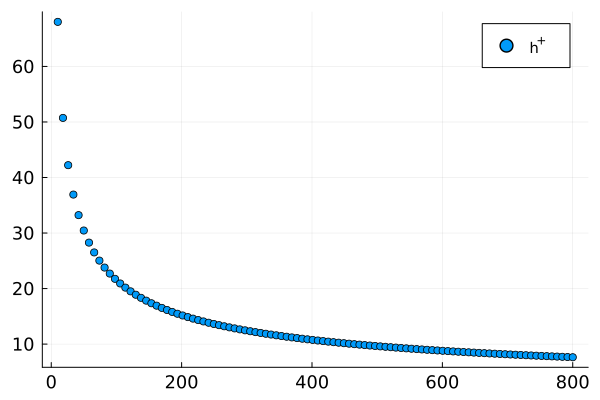

In [ ]:
plt_sommerfeld_h = plot(legendfontsize=10, yaxis=font(12), xaxis=font(12), dpi=600, show=true)
scatter!(plt_sommerfeld_h, temperature, sommerfeld_h, label=L"h^{\+}  \ \ (^{}$$")
xaxis!(L"\ T (K) \ (^{}$$");
yaxis!("Sommerfeld Parameter");
savefig("./sommerfeld_h.png")

### Electron capture

In [48]:
py"""
import numpy as np
from nonrad.scaling import sommerfeld_parameter, charged_supercell_scaling_VASP
"""
scaling_e = 1
sommerfeld_e = py"sommerfeld_parameter"([i for i in temperature], Z_e, m_e, ϵ_0)
scaling_e *= sommerfeld_e

charged_supercell_e = calc_charged_supercell_factor!(q_final, q_initial, defect_data["coupling state"], "e", Q_ref=defect_data["Q0"])
scaling_e /= charged_supercell_e

100-element Vector{Float64}:
 1.9728709301585294e-6
 3.46267330278152e-5
 0.00015418833694457953
 0.0004038630550588566
 0.0008052343761579927
 0.0013642516771352193
 0.0020775103743202535
 0.0029365444036612695
 0.003930459873942303
 0.005047480394233002
 0.006275825073412346
 0.007604186988211134
 0.009021975075692095
 ⋮
 0.14552508156226002
 0.1470262188065448
 0.14851837544466645
 0.15000162420645083
 0.1514760379430913
 0.1529416895599724
 0.15439865195484342
 0.15584699796095203
 0.15728680029477582
 0.1587181315080195
 0.16014106394356756
 0.16155566969510873

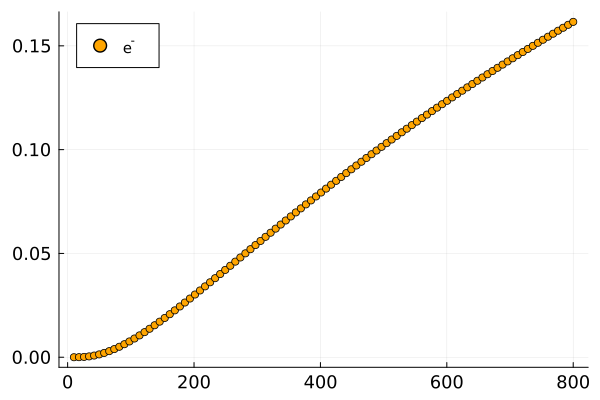

In [ ]:
plt_sommerfeld_e = plot(legendfontsize=10, yaxis=font(12), xaxis=font(12), dpi=600, show=true)
scatter!(plt_sommerfeld_e, temperature, sommerfeld_e, markercolor=:orange, label=L"e^{\-}  \ \ (^{}$$")
xaxis!(L"\ T (K) \ (^{}$$");
yaxis!("Sommerfeld Parameter");
savefig("./sommerfeld_e.png")

## 2.3 Scaled capture coefficients

### Hole capture

In [54]:
cc_h_capt_coeff_scaled = cc_h.capt_coeff .* scaling_h
cc_h_capt_coeff_scaled_spl = Spline1D(cc_h.temperature, cc_h_capt_coeff_scaled)
cc_h_capt_coeff_300 = cc_h_capt_coeff_scaled_spl(300)

2.9214922872193254e-10

In [55]:
cc_hplus_capt_coeff_scaled = cc_hplus.capt_coeff .* scaling_h;
cc_hminus_capt_coeff_scaled = cc_hminus.capt_coeff .* scaling_h;
cc_hexp_capt_coeff_scaled = cc_hexp.capt_coeff .* scaling_h;
cc_hexp_capt_coeff_scaled_spl = Spline1D(cc_h.temperature, cc_hexp_capt_coeff_scaled)
cc_hexp_capt_coeff_300 = cc_hexp_capt_coeff_scaled_spl(300)

2.5134663041026423e-8

In [56]:
cc_hexp_capt_coeff_600 = cc_hexp_capt_coeff_scaled_spl(600)

1.3369286719265283e-7

### Electron capture

In [57]:
cc_e_capt_coeff_scaled = cc_e.capt_coeff .* scaling_e
cc_e_capt_coeff_scaled_spl = Spline1D(cc_e.temperature, cc_e_capt_coeff_scaled)
cc_e_capt_coeff_300 = cc_e_capt_coeff_scaled_spl(300)

5.597391559626617e-22

In [58]:
cc_eplus_capt_coeff_scaled = cc_eplus.capt_coeff .* scaling_e;
cc_eminus_capt_coeff_scaled = cc_eminus.capt_coeff .* scaling_e;
cc_eexp_capt_coeff_scaled = cc_eexp.capt_coeff .* scaling_e;
cc_eexp_capt_coeff_scaled_spl = Spline1D(cc_e.temperature, cc_eexp_capt_coeff_scaled)
cc_eexp_capt_coeff_300 = cc_eexp_capt_coeff_scaled_spl(300)

2.3152519705171256e-21

In [59]:
cc_eexp_capt_coeff_600 = cc_eexp_capt_coeff_scaled_spl(600)

4.0964254145767896e-20

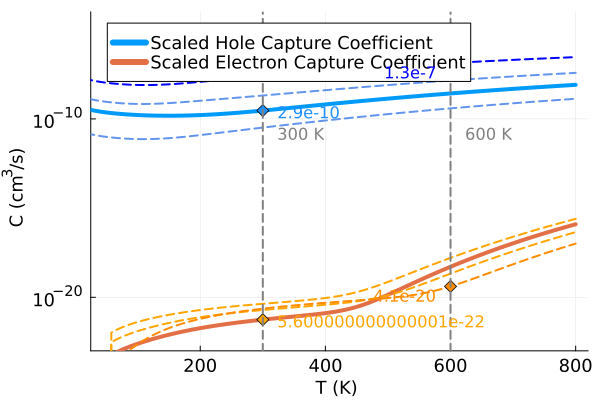

In [ ]:
using Plots
plt = plot(legendfontsize=12, legend=:topleft, yaxis = font(12), xaxis = font(12), dpi=600)
# plot scaled hole and electron capture coefficients
plot!(plt, cc_h.temperature, cc_h_capt_coeff_scaled, lw = 4, label = "Scaled Hole Capture Coefficient")
plot!(plt, cc_e.temperature, cc_e_capt_coeff_scaled, lw = 4, legend=:topleft, label = "Scaled Electron Capture Coefficient")

# plot hole capture coefficient uncertainty range and experimental (finite temperature) comparison
plot!(plt, cc_hplus.temperature, cc_hplus_capt_coeff_scaled, linestyle=:dash, lw = 2, color=:cornflowerblue, label = false)
plot!(plt, cc_hminus.temperature, cc_hminus_capt_coeff_scaled, linestyle=:dash, lw = 2, color=:cornflowerblue, label = false)
plot!(plt, cc_hexp.temperature, cc_hexp_capt_coeff_scaled, linestyle=:dash, lw = 2, color=:blue, label = false)

# plot labels for hole capture at 300 K and finite temperature comparison at 600 K
plot!([300], [cc_h_capt_coeff_300], label=false, marker=:diamond, markersize=6, markercolor=:dodgerblue)
annotate!(325, cc_h_capt_coeff_300*0.8, text(round(cc_h_capt_coeff_300, sigdigits=2), :dodgerblue, :left, 11))
plot!([600], [cc_hexp_capt_coeff_600], label=false, marker=:diamond, markersize=6, markercolor=:blue)
annotate!(575, cc_hexp_capt_coeff_600*0.3, text(round(cc_hexp_capt_coeff_600, sigdigits=2), :blue, :right, 11))

# plot electron capture coefficient uncertainty range and experimental (finite temperature) comparison
plot!(plt, cc_eplus.temperature, cc_eplus_capt_coeff_scaled, linestyle=:dash, lw = 2, color=:orange, label = false)
plot!(plt, cc_eminus.temperature, cc_eminus_capt_coeff_scaled, linestyle=:dash, lw = 2, color=:orange, label = false)
plot!(plt, cc_eexp.temperature, cc_eexp_capt_coeff_scaled, linestyle=:dash, lw = 2, color=:darkorange, label = false)

# plot labels for electron capture at 300 K and finite temperature comparison at 600 K
plot!([300], [cc_e_capt_coeff_300], label=false, marker=:diamond, markersize=6, markercolor=:orange)
annotate!(325, cc_e_capt_coeff_300*0.8, text(round(cc_e_capt_coeff_300, sigdigits=2), :orange, :left, 11))
plot!([600], [cc_eexp_capt_coeff_600], label=false, marker=:diamond, markersize=6, markercolor=:darkorange)
annotate!(575, cc_eexp_capt_coeff_600*0.3, text(round(cc_eexp_capt_coeff_600, sigdigits=2), :darkorange, :right, 11))

# plot lines denoting 300 K & 600 K
vline!(plt, [300], linestyle=:dash, lw=2, label=false, color=:grey)
annotate!(325, cc_h_capt_coeff_300*0.05, text("300 K", :grey, :left, 11))
vline!(plt, [600], linestyle=:dash, lw=2, label=false, color=:grey)
annotate!(625, cc_h_capt_coeff_300*0.05, text("600 K", :grey, :left, 11))

# plot parameters
xaxis!(L"\ T (K) \ (^{}$$");
yaxis!(L"C (cm^{3}\/s) \ (^{}$$", :log10)
xlims!(25, 820)
ylims!(1E-23, 1E-4)
savefig("./scaled_cap_coeff.png")

## 2.3 Capture cross section

Capture cross section is calculated by $\sigma$=𝐶/⟨𝑣⟩, where *C* is capture coefficient and *v* is thermal velocity.

In [71]:
Boltzmann = 1.3806504e-23;                              # kg m^2 / K s^2 
MassElectron = 9.10938188e-31;                          # kg

In [72]:
using Printf

T=300
v_e = sqrt(3*Boltzmann*T/(m_e*MassElectron))
v_h = sqrt(3*Boltzmann*T/(m_h*MassElectron))
@printf("Electron thermal velocity @ 300K in GaN: %.2e m/s\n", v_e)
@printf("Hole thermal velocity @ 300K in GaN: %.2e m/s", v_h)


Electron thermal velocity @ 300K in GaN: 2.61e+05 m/s
Hole thermal velocity @ 300K in GaN: 1.31e+05 m/s

In [73]:
function velocity_at_T(m_eff, T)
           sqrt(3*Boltzmann*T/(m_eff*MassElectron))
       end

velocity_at_T (generic function with 1 method)

### Hole capture

In [79]:
cc_h_xsec = (cc_h_capt_coeff_scaled ./ (velocity_at_T.(m_h, cc_h.temperature).*100))*(1e8)^2  # Angstroms^2
cc_h_xsec_spl = Spline1D(cc_h.temperature, cc_h_xsec)
cc_h_xsec_300 = cc_h_xsec_spl(300)
cc_h_xsec_600 = cc_h_xsec_spl(600)

1.4415913348507814

In [80]:
cc_hplus_xsec = (cc_hplus_capt_coeff_scaled ./ (velocity_at_T.(m_h, cc_hplus.temperature).*100))*(1e8)^2;
cc_hminus_xsec = (cc_hminus_capt_coeff_scaled ./ (velocity_at_T.(m_h, cc_hplus.temperature).*100))*(1e8)^2;
cc_hexp_xsec = (cc_hexp_capt_coeff_scaled ./ (velocity_at_T.(m_h, cc_hplus.temperature).*100))*(1e8)^2;
cc_hexp_xsec_spl = Spline1D(cc_h.temperature, cc_hexp_xsec)
cc_hexp_xsec_600 = cc_hexp_xsec_spl(600)

72.3968334536271

### Electron capture

In [81]:
cc_e_xsec = (cc_e_capt_coeff_scaled ./ (velocity_at_T.(m_e, cc_e.temperature).*100))*(1e8)^2  # Angstroms^2
cc_e_xsec_spl = Spline1D(cc_e.temperature, cc_e_xsec)
cc_e_xsec_300 = cc_e_xsec_spl(300)
cc_e_xsec_600 = cc_e_xsec_spl(600)

1.3966772933763434e-10

In [82]:
cc_eplus_xsec = (cc_eplus_capt_coeff_scaled ./ (velocity_at_T.(m_e, cc_eplus.temperature).*100))*(1e8)^2;
cc_eminus_xsec = (cc_eminus_capt_coeff_scaled ./ (velocity_at_T.(m_e, cc_eplus.temperature).*100))*(1e8)^2;
cc_eexp_xsec = (cc_eexp_capt_coeff_scaled ./ (velocity_at_T.(m_e, cc_eplus.temperature).*100))*(1e8)^2;
cc_eexp_xsec_spl = Spline1D(cc_e.temperature, cc_eexp_xsec)
cc_eexp_xsec_600 = cc_eexp_xsec_spl(600)

1.1091400727492015e-11

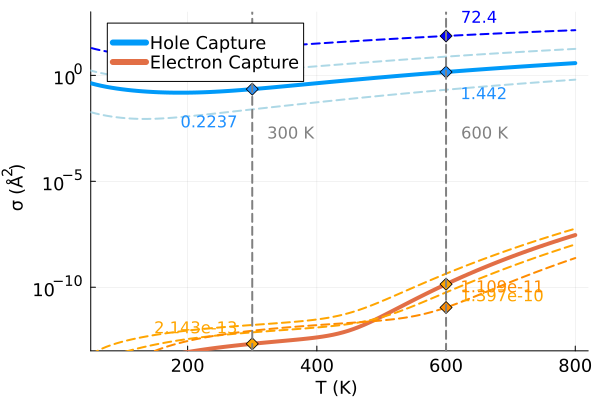

In [ ]:
using Plots
plt = plot(legendfontsize=12, legend=:topleft, yaxis = font(12), xaxis = font(12), dpi=600)
# plot hole and electron capture cross-sections
plot!(plt, cc_h.temperature, cc_h_xsec, lw = 4, label = "Hole Capture")
plot!(plt, cc_e.temperature, cc_e_xsec, lw = 4, label = "Electron Capture")

# plot hole & electron capture cross-section uncertainty range and experimental (finite temperature) comparison
plot!(plt, cc_hplus.temperature, cc_hplus_xsec, linestyle=:dash, lw = 2, color=:lightblue, label = false)
plot!(plt, cc_hminus.temperature, cc_hminus_xsec, linestyle=:dash, lw = 2, color=:lightblue, label = false)
plot!(plt, cc_hexp.temperature, cc_hexp_xsec, linestyle=:dash, lw = 2, color=:blue, label = false)

plot!(plt, cc_eplus.temperature, cc_eplus_xsec, linestyle=:dash, lw = 2, color=:orange, label = false)
plot!(plt, cc_eminus.temperature, cc_eminus_xsec, linestyle=:dash, lw = 2, color=:orange, label = false)
plot!(plt, cc_eexp.temperature, cc_eexp_xsec, linestyle=:dash, lw = 2, color=:darkorange, label = false)

# plot labels for hole & electron capture at 300 K and finite temperature comparison at 600 K
plot!([300], [cc_h_xsec_300], label=false, marker=:diamond, markersize=6, markercolor=:dodgerblue)
annotate!(275, cc_h_xsec_300*0.03, text(round(cc_h_xsec_300, sigdigits=4), :dodgerblue, :right, 11))
plot!([600], [cc_h_xsec_600], label=false, marker=:diamond, markersize=6, markercolor=:dodgerblue)
annotate!(625, cc_h_xsec_600*0.1, text(round(cc_h_xsec_600, sigdigits=4), :dodgerblue, :left, 11))
plot!([600], [cc_hexp_xsec_600], label=false, marker=:diamond, markersize=6, markercolor=:blue)
annotate!(625, cc_hexp_xsec_600*8, text(round(cc_hexp_xsec_600, sigdigits=4), :blue, :left, 11))

plot!([300], [cc_e_xsec_300], label=false, marker=:diamond, markersize=6, markercolor=:orange)
annotate!(275, cc_e_xsec_300*6, text(round(cc_e_xsec_300, sigdigits=4), :orange, :right, 11))
plot!([600], [cc_e_xsec_600], label=false, marker=:diamond, markersize=6, markercolor=:orange)
annotate!(625, cc_e_xsec_600*0.3, text(round(cc_e_xsec_600, sigdigits=4), :orange, :left, 11))
plot!([600], [cc_eexp_xsec_600], label=false, marker=:diamond, markersize=6, markercolor=:darkorange)
annotate!(625, cc_eexp_xsec_600*10, text(round(cc_eexp_xsec_600, sigdigits=4), :darkorange, :left, 11))

# plot lines denoting 300 K & 600 K
vline!(plt, [300], linestyle=:dash, lw=2, label=false, color=:grey)
annotate!(325, 2E-3, text("300 K", :grey, :left, 11))
vline!(plt, [600], linestyle=:dash, lw=2, label=false, color=:grey)
annotate!(625, 2E-3, text("600 K", :grey, :left, 11))

# plot parameters
xaxis!(L"\ T (K) \ (^{}$$");
yaxis!(L"\sigma (Å^{2}) \ (^{}$$", :log10)
xlims!(50, 820)
ylims!(1E-13, 1E3)
savefig("./cap-xsec.png")